## BÀI TẬP VỀ NHÀ 

Hãy sử dụng dữ liệu và 1 phần code đã làm ở bài tập thực hành trên lớp, để thực hiện các việc sau:

1. Thử nghiệm thuật toán trích xuất đặc trưng BoW với số lượng từ trong từ điển khác nhau. Vẽ biểu đồ độ chính xác trên tập test ứng với từng trường hợp.

2. Sử dụng thuật toán Grid search kết hợp với Cross Validation tìm tham số tốt nhất cho mô hình SVM.

3. Thay SVM bằng các bộ phân loại: K-Nearest Neighbors, Decision tree, Random forest. So sánh các kết quả và đưa ra nhận xét. 

4. Optional: Sử dụng HOG để biểu diễn ảnh, và 1 bộ phân lớp nào đó để phân loại ảnh


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
def load_image(image_path):  
    return cv2.imread(image_path)

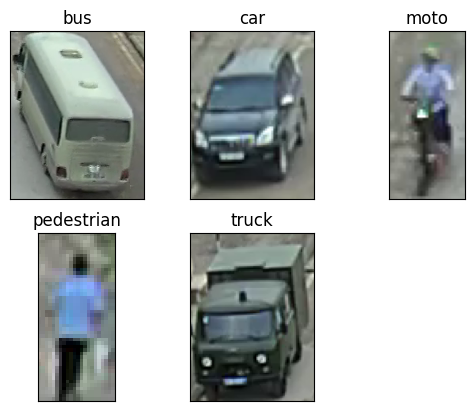

In [3]:
# read some samples from dataset
samples_list = [] # list of images
samples_label = [] # list of corresponding labels
for label in os.listdir('trainingset',):
    sample_file = os.listdir(os.path.join('trainingset', label))[0] # 1st filename in each sub-directory (label)
    samples_list.append(load_image(os.path.join('trainingset', label, sample_file))) # read training images and save to the list
    
    samples_label.append(label) # corresponding labels

    
for i in range(len(samples_list)):
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i]), plt.xticks([]), plt.yticks([])
    
plt.show()

### I.2: Thống kê dữ liệu
Hãy lập trình hàm statistic() để thống kê số lượng ảnh ứng với mỗi nhãn. Hàm statistic() cần trả về 2 danh sách (list): label, num_images. Danh sách label lưu tên các nhãn và danh sách num_images lưu số lượng ảnh tương ứng với nhãn lưu ở danh sách label.

In [4]:
def statistic():
    label = []
    num_images = []

    for label_name in os.listdir('trainingset'):
        label.append(label_name)
        num_images.append(len(os.listdir(os.path.join('trainingset', label_name))))

    return label, num_images

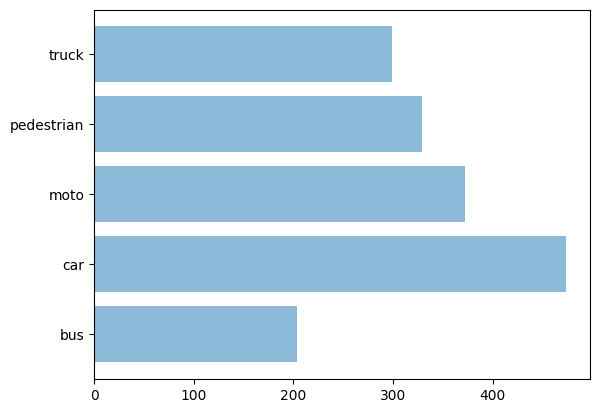

Total images: 1678


In [5]:
# lấy các nhãn và hiển thị số liệu mẫu với từng tập dữ liệu
label, num_images = statistic()

y_pos = np.arange(len(label))
plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

### I.3: Xây dựng danh sách chứa ảnh

Để tiện cho việc lập trình các bước tiếp theo ta sẽ xây dựng một list lưu trữ ảnh và nhãn tương ứng của nó. Hãy lập trình hàm read_data(), hàm này trả về hai list X, Y, trong đó mỗi phần tử của list X lưu trữ một mảng numpy biểu diễn một ảnh và mỗi phần tử của list Y lưu trữ nhãn (dưới dạng số nguyên) tương ứng của ảnh.

In [6]:
# Read images and its corresponding labels from training set
def read_data(label2id):
    X = [] # images
    Y = [] # index of corresponding labels
    
    for label in os.listdir('trainingset'):
        for image_path in os.listdir(os.path.join('trainingset', label)):
            img = load_image(os.path.join('trainingset', label, image_path))
            X.append(img)
            Y.append(label2id[label])     
    
    return X, Y

In [7]:
# Label to id, used to convert string label to integer 
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}

# Read data
X, Y = read_data(label2id)

# Show some examples
print(len(X))
print(len(Y))
for i in range(5):
    print(X[i].shape)
    print(Y[i])

1678
1678
(168, 134, 3)
4
(270, 193, 3)
4
(168, 120, 3)
4
(107, 83, 3)
4
(97, 80, 3)
4


## II: Biểu diễn nội dung bức ảnh - trích xuất đặc trưng (features extraction)

Ở phần này chúng ta sẽ lần lượt thực hiện các công việc: trích xuất đặc trưng SIFT (SIFT keypoints descriptor), xây dựng từ điển và mô hình Bag-of-Word (BoW). Bạn hãy lập trình hoàn chỉnh các hàm theo yêu cầu cụ thể dưới đây

### II.1: Trích xuất đặc trưng SIFT

Hãy lập trình hàm extract_sift_features() nhận đầu vào là list ảnh ta đã xây dựng được từ câu hỏi trước và trả về:
- list image_descriptors, 
- phần tử thứ p trong list image_descriptors lại là một list chứa các SIFT descriptors ứng với ảnh thứ p trong list X.

Gợi ý: 
- Để khởi tạo đối tượng SIFT trong OpenCV ta sử dụng lệnh: sift = cv2.xfeatures2d.SIFT_create() hoặc cv2.SIFT_create() tùy version. 
- Đối tượng này có phương thức detectAndCompute trả về 2 outputs kp và des, kp là một list chứa các keypoints được detect bởi SIFT, des là một numpy array chứa len(kp) vectors 128 chiều. 

In [8]:
# Input: list of images (X)
# Output: list of local features extracted from image in X.
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.SIFT_create()

    for i in range(len(X)):
        kp, des = sift.detectAndCompute(cv2.cvtColor(X[i], cv2.COLOR_BGR2GRAY), None)
        image_descriptors.append(des)


    return image_descriptors

In [9]:
# test: feature extraction
image_descriptors = extract_sift_features(X)

print(len(image_descriptors))
print(type(image_descriptors[0][0]))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1678
<class 'numpy.ndarray'>
Image 0 has 109 descriptors
Image 1 has 148 descriptors
Image 2 has 57 descriptors
Image 3 has 29 descriptors
Image 4 has 83 descriptors
Image 5 has 28 descriptors
Image 6 has 219 descriptors
Image 7 has 22 descriptors
Image 8 has 62 descriptors
Image 9 has 181 descriptors


### II.2: Xây dựng từ điển
Hãy lập trình hàm kmeans_bow():
- input: list gồm tất cả các descriptors của các ảnh trong tập X và số cụm num_clusters. Có thể sử dụng thuật toán KMeans trong scikit-learn phân cụm các vector descriptors này thành num_clusters cụm
- output: danh sách tâm của các cụm. Danh sách tâm cụm này chính là tương ứng với từ điển (hay tập các từ trực quan). 

Lưu ý: 
- Từ điển là danh sách tham chiếu đến khi biểu diễn nên cần lưu lại
- Quá trình xây dựng cũng tiêu tốn thời gian nên chúng ta chỉ xây dựng lại từ điển khi cần thiết. 
==> Từ điển xây dựng xong cần lưu ra một file nhị phân (sử dụng thư viện pickle) để tiện sử dụng sau này.

In [10]:
#Trước tiên ta sẽ xây dựng một list chứa tất cả các descriptors từ tập ảnh ban đầu (tập ảnh tham chiếu, tập dữ liệu mẫu)
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 155516


In [11]:
# Hãy lập trình hàm kmeans_bow().

# Gợi ý: Trong thư viện sklearn, để khởi tạo một đối tượng kmeans ta sử dụng lệnh:
#       kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)

#       kmeans có phương thức fit, nhận vào các điểm dữ liệu (trong bài toán hiện tại của chúng ta là list all_descriptors) 
#              và tìm ra n_clusters vector là tâm của các cụm dữ liệu. 
#              Để lấy được các vector này ta sử dụng thuộc tính $cluster_centers_$  của đối tượng kmeans
import time

def kmeans_bow(all_descriptors, num_clusters):
    start = time.time()
    
    bow_dict = []

    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    print('Process time: ', time.time() - start)

    return bow_dict

In [12]:
# Thực hiện phân cụm để xây dựng từ điển và lưu ra 1 file 
num_clusters = 50
if not os.path.isfile('bow_dictionary4.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary.pkl', 'rb'))
    # BoW = pickle.load(open('bow_dictionary.pkl', 'rb'), encoding='latin1')
    
print(len(BoW))
print(type(BoW[0]))

  File "c:\Users\Gia Bao\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Process time:  33.37161827087402
50
<class 'numpy.ndarray'>


### II.3: Xây dựng vector đặc trưng với mô hình BoW

Hãy xây dựng hàm create_features_bow():
- input: list image_descriptors, list chứa các từ trực quan (tâm cụm) và số từ (num_clusters) ở trên, 
- output: trả về list X_features, X_features[p] là vector biểu diễn theo mô hình BOW ứng với ảnh thứ p: tần suất xuất hiện của từ. Hãy chú ý sự tương ứng các phần tử trong 4 danh sách: X, Y, image_descriptors, X_features.

In [13]:
from scipy.spatial.distance import cdist

In [14]:
# Input: 
#    image_descriptors: each list element contains a list of local features of 1 image
#    BoW: list of visual word representation
#    num_clusters: number of visual words
# Output:
#    X_features: each list element = bag-of-words vector of 1 image

def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)): # i: list index of local descriptors for each image
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW) # distance from local feature to all words
            #### YOUR CODE HERE ####
            # Find the nearest word
            # Assign the corresponding bin to 1
            # Hint: use np.argmin

            for j in range(len(image_descriptors[i])):
                nearest_word = np.argmin(distance[j])
                features[nearest_word] += 1

                

        X_features.append(features)


    return X_features

In [15]:
print(image_descriptors[0].shape)
print(BoW[0].shape)
X_features = create_features_bow(image_descriptors, BoW, num_clusters)
print(len(X_features))
print(X_features[0])
print(sum(X_features[0]))
print(image_descriptors[0].shape[0])

(109, 128)
(128,)
1678
[ 1  2  3  3  5  3  2  1  6  5  4  2  1  3  0  2  2  1  5  3  1  2  1  3
  0  0  2  1  2  0  1  1  0  9  1 10  3  0  0  3  0  5  1  2  0  0  3  0
  3  1]
109
109


## III: Xây dựng mô hình phân loại
Từ các câu hỏi trước chúng ta đã xây dựng được vector đặc trưng ứng với mỗi ảnh trong bộ dữ liệu. Ở câu hỏi này chúng ta sẽ xây dựng các mô hình phân loại SVM

In [16]:
print(len(X_features))
print(len(Y))

1678
1678


Chia tập dữ liệu thành tập train/test:

In [17]:
from sklearn.model_selection import train_test_split

X_train = [] 
X_test = []
Y_train = []
Y_test = []

# Split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

1342
336


## Model Selection

In [18]:
# cross validation
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Train a SVM classifier
clf = SVC(kernel='linear', C=1)

# grid search 
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'linear']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, Y_train)

print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)


#cross validation
scores = cross_val_score(clf, X_train, Y_train, cv=3)
print('Cross validation scores: ', scores)

# Train the classifier
clf.fit(X_train, Y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.275 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.275 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.276 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.272 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.276 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.703 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.714 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.675 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.694 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.275 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;

SVC(C=1, kernel='linear')

In [27]:
clf = SVC(kernel='linear', C=1, gamma=1)

In [29]:
clf.fit(X_train, Y_train)

SVC(C=1, gamma=1, kernel='linear')

Tính độ chính xác trên tập dữ liệu test:

In [30]:
# Tính độ chính xác trên tập dữ liệu huấn luyện:
clf.score(X_train, Y_train)

0.8137108792846498

In [31]:
# Tính độ chính xác trên tập dữ liệu test:
clf.score(X_test, Y_test)

0.6726190476190477

Vẽ confusion matrix kết quả dự đoán trên tập test và in accuracy của từng nhãn lớp.

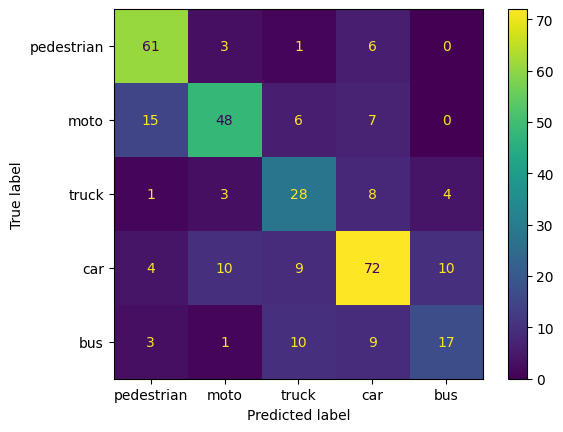

In [33]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

Y_predict = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(Y_test, Y_predict, display_labels=list(label2id.keys()))
plt.show()

Một vài kết quả dự đoán trên tập test.

In [34]:
label_dict = {v: k for k, v in label2id.items()}
print(label_dict)

{0: 'pedestrian', 1: 'moto', 2: 'truck', 3: 'car', 4: 'bus'}


## KNN, Decision Tree, Random Forest

In [35]:
# import KNN, DecisionTree, RandomForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

list_model = [KNeighborsClassifier(n_neighbors=3), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]

for model in list_model:
    model.fit(X_train, Y_train)
    print('Model: ', model)
    print('Train score: ', model.score(X_train, Y_train))
    print('Test score: ', model.score(X_test, Y_test))
    print('Confusion matrix:')
    Y_predict = model.predict(X_test)
    print(confusion_matrix(Y_test, Y_predict))

    best_model = model
    if model.score(X_test, Y_test) > best_model.score(X_test, Y_test):
        best_model = model

# Save the best model
pickle.dump(best_model, open('best_model.pkl', 'wb'))

# Load the best model
best_model = pickle.load(open('best_model.pkl', 'rb'))

# Test the best model
print('Test score: ', best_model.score(X_test, Y_test))


Model:  KNeighborsClassifier(n_neighbors=3)
Train score:  0.8144560357675111
Test score:  0.6398809523809523
Confusion matrix:
[[60  7  0  4  0]
 [10 58  1  7  0]
 [ 4  5 22  6  7]
 [12 26  4 59  4]
 [ 5  3  7  9 16]]
Model:  DecisionTreeClassifier()
Train score:  1.0
Test score:  0.5416666666666666
Confusion matrix:
[[50  7  1 11  2]
 [16 43  1 13  3]
 [ 2  7 21 10  4]
 [ 6 14 14 56 15]
 [ 2  2 11 13 12]]
Model:  RandomForestClassifier()
Train score:  1.0
Test score:  0.6696428571428571
Confusion matrix:
[[59 11  0  1  0]
 [ 7 56  2 11  0]
 [ 1  1 28 12  2]
 [ 7 13  8 73  4]
 [ 2  2 16 11  9]]
Test score:  0.6696428571428571


## Conclusion


Best model is SVM with C=1, gamma=0.1, kernel = 'linear'
